Initial version of alpha comments in each cell with markdown explanation where needed. Default values aren't particularly based on anything physical, development of a Milky Way like model will come later. 

Example model and plots at the end to show functionality.

In [1]:
import numpy as np
from scipy import integrate as integrate
import omega
import matplotlib.pyplot as plt
%matplotlib nbagg

In [2]:
def make_zones(mass, start_radius , end_radius, n_zones, kwargs_list = [{}]):
    
    """Make the number of omega zones as required.
    
    Input Parameters:
    =================
    
    mass: float
    Initial mass of the gas in the galaxy [Msun]
    
    start_radius: float
    Inside radius of the galaxy [kpc]
    
    end_radius: float:
    Outside radius of the galaxy [kpc]
    
    n_zones: float
    Number of zones required
    
    kwargs_list: dictionary
    Properties of the chemical evolution model (see chem_evol, sygma, omega)
    
    """
    
    zone_radii = np.linspace(start_radius, end_radius, n_zones+1)
    
    bins = [] #array for all of the bins
    for i in range(len(zone_radii)):
        rin = zone_radii[i] #radius of each bin by index
        if i+1 == n_zones+1:
            break
        else:
            rout = zone_radii[i+1]
            zone_mass = mass/n_zones #split mass evenly across the zones
            centre = (rout - rin)/2 + rin #calculate the centre of the bin
            
            
            gal_bin = [i, rin, rout, centre, zone_mass] #bin properties
            #index, inner radius of the zone, outer radius of the zone, centre point of the zone, initial mass
            
            bins.append(gal_bin)
            
    vers = [] #version 'number'
    omegas = {} #dictionary of all the omegas corresponding to each zone
    
    for i in range(len(bins)):
        ver = 'omega'+str(i)
        vers.append(ver)
        if len(kwargs_list) <=1:
            omegas[ver] = omega.omega(external_control = True, in_out_control = True, mgal = bins[i][4], **kwargs_list[0]) #make an omega for each zone
        if len(kwargs_list) > 1:
            omegas[ver] = omega.omega(external_control = True, in_out_control = True, mgal = bins[i][4], **kwargs_list[i]) #custom kwargs for each zone

    
    return vers, omegas, bins

Sorting the gas infalling onto each zone

In [3]:
def fr(r,h):
    
    """ 
    Radially dependent part of the normalisation integral for the gas infall.
    
    r: float
    Radius of the galaxy [kpc]
    
    h: float
    Disk scale height [kpc]
    
    """
    
    return np.exp(-r/h)

In [4]:
def ft(r, t_end, a = -1.267, b = 1.033):   
    
    """
    Time dependent part of the normalisation integral for the gas infall.
    
    r: float
    Radius of the galaxy [kpc]
    
    t_end: float 
    Age of the galaxy at the end of the simulation [Gyr]
    
    a: float
    Infall timescale at the galaxy centre [Gyr]
    
    b: float
    Gradient of the infall timescale [Gyr kpc-1]
    
    """
    
    val_t, err_t = integrate.quad(lambda t: np.exp(-t/(a + b*r)), 0, t_end)
    
    #units of val_t = Gyr
    
    return val_t

In [5]:
def get_area(index, bins):
    
    """
    Find area of a zone.
    
    index: int
    Index of the zone 
    
    bins:list
    List of bins containing the galaxy properties
    
    """
    
    if index == 0:
        Ar = np.pi * (bins[index][2])**2
    else:
        Ar = (np.pi * bins[index][2]**2) - (np.pi * bins[index-1][2]**2)
    
    return Ar

In [6]:
def inflows(i_t, index, bin_radius, omega_zone, minf, bins, a = -1.267, b = 1.033):
    
    """Calculate the gas infall onto each zone. Returns mass of the infalling gas [Msun kcp-2], 
    chemical composision of the infalling gas in [Msun kpc-2] for each isotope and the inflow rate of the gas 
    [Mo yr-1 kpc-2]
    
    Input Parameters:
    =================
    
    i_t: float
    Timestep index for the timestep of interest
    
    index:int
    Index of the zone
    
    bin_radius: float
    Mid-point radius of the zone of interest [kpc]
    
    omega_zone: dictionary entry
    OMEGA instance of interest
    
    minf: float
    Total mass of gas infalling throughout the simulation [Mo]
    
    bins:list 
    List of bins
    
    a: float
    Infall timescale at the galaxy centre [Gyr]
    
    b: float
    Gradient of the infall timescale [Gyr kpc-1]
    """
    
    h = 3.5 #kpc from Palla et al (which was from Spitoni, Gioanna and Matteucci 2017)
    
    if a == -1.267 and b == 1.033:
        A = minf/integrate.quad(lambda r: 2*np.pi*r*fr(r, h)*ft(r,omega_zone.history.tend/10**9), bins[0][1], bins[-1][2])[0]
        tau = b*bin_radius + a #chiappini 2001
        
    else:
        A = minf/integrate.quad(lambda r: 2*np.pi*r*fr(r, h)*ft(r,omega_zone.history.tend/10**9, a, b), bins[0][1], bins[-1][2])[0]
        tau = a+b*bin_radius
        
    
    i0 = A*np.exp(-bin_radius/h) #Msun Gyr-1 kpc-2
        
    t = omega_zone.history.age[i_t]/10**9 #Gyr
        
    inf_rate = i0*np.exp(-t/tau)/10**9 #Msun yr-1 kpc-2
    
    if i_t != len(omega_zone.history.age) -1 :
    
        m_gas_inf = inf_rate * (omega_zone.history.age[i_t + 1] - omega_zone.history.age[i_t]) \
        * get_area(index, bins) #Msun
    
        ym_inf = omega_zone.prim_comp.get(quantity = 'Yields', Z = 0.0) * m_gas_inf
    
    else:
        m_gas_inf = inf_rate * 0 * get_area(index, bins)
        
        ym_inf = m_gas_inf * omega_zone.prim_comp.get(quantity = 'Yields', Z = 0.0)

    return m_gas_inf, ym_inf, inf_rate #mass of the gas, chemical compostition and inflow rate

In [7]:
def outflows(mass_loading, sfr, omega_zone, i_t, index, bins):
    
    """Calculate the gas outflow from each zone. Returns mass of the outflowing gas [Mo kcp-2], 
    chemical composision of the outflowing gas and the outflow rate of the gas [Mo Gyr-1 kpc-2]
    
    mass_loading:float 
    Dimensionless ratio between the outflow rate and the star formation rate
    
    sfr: float
    Star formation rate of the zone at the timestep you are interested in [Mo yr-1 kcp-2]
    
    omega_zone: dictonary entry
    OMEGA instance of interest
    
    i_t: float
    Timestep index for the timestep of interest

    """
    
    out_rate = mass_loading * sfr #Mo yr-1 kpc-2
    
    
    if i_t != len(omega_zone.history.age) -1 :
        m_gas_out = out_rate * (omega_zone.history.age[i_t + 1] - omega_zone.history.age[i_t]) \
        * get_area(index, bins) #Mo
    
        ym_out = omega_zone.prim_comp.get(quantity = 'Yields', Z = 0.0) * m_gas_out
    
    else:
        m_gas_out = out_rate * 0 * get_area(index, bins)
        
        ym_out = m_gas_out * omega_zone.prim_comp.get(quantity = 'Yields', Z = 0.0)
    
    return m_gas_out, ym_out, out_rate

In [8]:
def migration(index, vers, omegas, bins, fstar, i_t, coeff, minf, mass_loading, a = -1.267, b = 1.033, KS_pow = 1):
    
    """Function to move the gas in and out of each zone via inflow, outflow and radial flow.
    
    Input Parameters:
    =================
    
    index: int
    Index of the omega zone from 0 to number of zones-1. The value must be an integer
    
    vers: list
    List of the omega zone version names
    
    omegas: dictionary
    Dictionary of the omega instances createed for each zone
    
    bins:list 
    List of bins
    
    f_star: float
    Star formation efficiency [yr-1]
    
    i_t: float
    Timestep index through the evolution when the migration is occurring
    
    coeff: float
    Constant coefficient for the migration of gas, as a percentage of total mass in the zone
    (Default = 0, i.e. no radial flows)
    
    minf: float
    Total mass of gas infalling throughout the simulation [Mo]
    
    mass_loading:float 
    Dimensionless ratio between the outflow rate and the star formation rate
    
    a: float
    Infall timescale at the galaxy centre [Gyr]
    
    b: float
    Gradient of the infall timescale [Gyr kpc-1]
    
    KS_pow: float
    Value of exponent if using modified Kennicutt-Schmdit SF law
    (Default = 1)
    
    """
    
    #calculation for gas surface density for the zone
    #and setting a threshold of gas surface density needed to form stars
    mass_sum = sum(omegas[vers[index]].ymgal[i_t])
    gas_surf_density = (mass_sum/get_area(index, bins))*10**6 #Mo pc-2
    
    if gas_surf_density < 7:
        sfr =0
    else:
        sfr = (fstar*(sum(omegas[vers[index]].ymgal[i_t])/get_area(index, bins)))**KS_pow #Mo yr-1 kpc-2
    
    if index == 0: #radial movement for the innermost zone
        m_gas_X_prev = coeff*omegas[vers[index+1]].ymgal[i_t] #Mo for each isotope
        gas_gained = m_gas_X_prev + inflows(i_t, index, bins[index][3], omegas[vers[index]], minf, bins, a, b)[1] #Mo for each iso
        gas_lost = 0.0 + outflows(mass_loading, sfr, omegas[vers[index]], i_t, index, bins)[0] #Mo
    
    elif index == len(vers) -1: #radial movement for the outermost zone
        m_gas_X_current = coeff*omegas[vers[index]].ymgal[i_t] #Mo for each isotope
        m_gas = sum(m_gas_X_current) #Mo
        gas_gained = np.zeros(283) + inflows(i_t, index, bins[index][3], omegas[vers[index]], minf, bins, a, b)[1] #Mo for each isotope
        gas_lost = m_gas + outflows(mass_loading, sfr, omegas[vers[index]], i_t, index, bins)[0] #Mo
        
    else:
        m_gas_X_prev = coeff*omegas[vers[index+1]].ymgal[i_t] #Mo for each isotope
        m_gas_X_current = coeff*omegas[vers[index]].ymgal[i_t] #Mo for each isotope
        m_gas = sum(m_gas_X_current) #Mo
        gas_gained = m_gas_X_prev + inflows(i_t, index, bins[index][3], omegas[vers[index]], minf, bins, a, b)[1] #Mo for each isotope
        gas_lost = m_gas + outflows(mass_loading, sfr, omegas[vers[index]], i_t, index, bins)[0] #Mo
        
    return sfr, gas_lost, gas_gained #[Mo yr-1 kpc-2], Mo, Mo for each isotope

In [9]:
def check_mass(omega_zone, t):
    
    """
    Checking mass of a zone at a given timestep. If the mass is negative, stop the run.
    
    omega_zone: dictionary entry
    OMEGA instance of interest
    
    t:float
    Time at which the mass should be checked"""
    
    z_mass = sum(omega_zone.ymgal[t])
    if z_mass <= 0:
        print('Negative mass - end run')
    
    return

In [10]:
def multizone(n_zones=10, mass=10e-12, start_radius=4, end_radius=16.5, fstar=2.3e-10, coeff=0, minf=10e11, mass_loading=0, kwargs_list=[{}], a = -1.267, b = 1.033, KS_pow = 1, return_info = False):
    
    
    """Function which combines the capailities of make_zones, inflows and migration in order to make 
    the required number of omega zones and move gas between them at each timestep.
    
    Input Parameters:
    =================
    
    n_zones:float
    Number of zones required for the model
    
    mass: float
    Initial mass of the gas in the galaxy [Mo]
    
    start_radius: float
    Inside radius of the galaxy [kpc]
    
    end_radius: float:
    Outside radius of the galaxy [kpc]
    
    fstar: float
    Star formation efficiency [yr-1]
    
    coeff: float
    Constant coefficient for the migration of gas, as a percentage of total mass in the zone
    
    minf: float
    Total mass of gas infalling throughout the simulation [Mo]
    
    a: float
    Infall timescale at the galaxy centre [Gyr]
    
    b: float
    Gradient of the infall timescale [Gyr kpc-1]
    
    KS_pow: float
    Value of exponent if using modified Kennicutt-Schmdit SF law
    (Default = 1)
    
    mass_loading:float 
    Dimensionless ratio between the outflow rate and the star formation rate
    
    kwargs_list: dictionary
    Properties of the chemical evolution model (see chem_evol, sygma, omega)
    
    return_info: boolean
    Return the migration information: star formation rate [Mo yr-1 kpc-2], mass of gas lost [Mo], mass of gas gained [Mo for each isotope]
    Default Value: False, to activate return_info = True
    
    """
    
    vers, omegas, bins = make_zones(mass, start_radius, end_radius, n_zones)
    o_default = omega.omega(**kwargs_list[0]) #this may need to be altered with parameters that dictate length of timestep etc.
    migr_info = []
    for t in range(o_default.nb_timesteps):
        migr_info.append([])
        for i in range(len(vers)):
            migr_info[t].append(migration(i, vers, omegas, bins, fstar, t, coeff, minf, mass_loading, a, b, KS_pow))
            check_mass(omegas[vers[i]], t)
            omegas[vers[i]].run_step(t+1, migr_info[t][i][0], m_lost = migr_info[t][i][1], m_added = migr_info[t][i][2])
   
    if return_info == True:   
        return vers, omegas, bins, migr_info
    else:
        return vers, omegas, bins
   

    #with the addition of inflows and potentially outflows, migr_info provides info about the gas gained and lost 
    #from each zone but not necessarily the migration information

In [11]:
def get_inflow_rate(i_t, index, bin_radius, omega_zone, minf, bins, a = -1.267, b = 1.033):
    
    """Find the inflow rate for a given radius at a given time"""
    
    return inflows(i_t, index, bin_radius, omega_zone, minf, bins, a, b)[2]

In [12]:
def get_radii(bins):

    """Finds the mid-point radius of each zone"""
    
    radii = []
    
    for i in range(len(bins)):
        
        rads = bins[i][3]
        radii.append(rads)
        
    return radii    

In [13]:
def plot_inflow_rate(vers, omegas, bins, i_t, minf, a = -1.267, b = 1.033):
    
    """Plots the inflow rate as a function of radius for a given timestep
    
    vers: list
    List of the omega zone version names
    
    omegas: dictionary
    Dictionary of the omega instances createed for each zone
    
    bins:list 
    List of bins created by the initial omega run
    
    """
    
    in_rate = []
    
    for i in range(len(omegas)):
        rate = get_inflow_rate(i_t, i, bins[i][3], omegas[vers[i]], minf, bins, a = -1.267, b = 1.033)
        in_rate.append(rate)
        
    plt.plot(get_radii(bins), in_rate, marker = 'o', label = "{0:.2f}".format(omegas['omega0'].history.age[i_t]/10**9) + 'Gyr') #label would be better as age but leave for now
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.ylabel('Inflow Rate (M$_{\odot}$yr$^{-1}$kpc$^{-2}$)', fontsize = 14)
    plt.xlabel('Radius (kpc)', fontsize = 14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
    return

In [14]:
def get_radial_SFR(vers, omegas, bins, fstar, i_t, KS_pow = 1):
    
    """Get the SFR [Mo yr-1 kpc-2] as a function of radius (inside out) for a given timestep"""
    
    rad_sfr = []
    
    for i in range(len(omegas)):    
        #calculation for gas surface density for the zone:
        mass_sum = sum(omegas[vers[i]].ymgal[i_t])
        gas_surf_density = (mass_sum/get_area(i, bins))*10**6 #Mo pc-2
        
        if gas_surf_density < 7:
            star_form_rate = 0
        else:
            star_form_rate = (fstar * (sum(omegas[vers[i]].ymgal[i_t])/get_area(i, bins)))**KS_pow
        
        rad_sfr.append(star_form_rate)
    
    return rad_sfr

In [15]:
def plot_radial_sfr(vers, omegas, bins, fstar, i_t):
    
    """Plot star formation rate as a function of radius for a given timestep."""
    
    plt.plot(get_radii(bins), get_radial_SFR(vers, omegas, bins, fstar, i_t), marker = 'o', label = "{0:.2f}".format(omegas['omega0'].history.age[i_t]/10**9) + 'Gyr')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.ylabel('SFR (M$_{\odot}$yr$^{-1}$kpc$^{-2}$)', fontsize = 14)
    plt.xlabel('Radius (kpc)', fontsize = 14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
    return

In [16]:
def get_outflow_rate(vers, omegas, bins, fstar, mass_loading, i_t, KS_pow = 1):
    
    """Find outflow [Mo yr-1kpc-2] rate as a function of radius for a given timestep"""
    
    rad_outflow = []
    
    for i in range(len(omegas)):
        sfr = get_radial_SFR(vers, omegas, bins, fstar, i_t, KS_pow)
        
    for j in sfr:
        out = mass_loading * j
        rad_outflow.append(out)
        
    
    return rad_outflow

In [17]:
def plot_outflow_rate(vers, omegas, bins, fstar, mass_loading, i_t):
    
    """Plot outflow rate as a function of radius for a given timestep."""
    
    plt.plot(get_radii(bins), get_outflow_rate(vers, omegas, bins, fstar, mass_loading, i_t), marker = 'o', \
            label = "{0:.2f}".format(omegas['omega0'].history.age[i_t]/10**9) + 'Gyr')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.ylabel('Outflow Rate (M$_{\odot}$yr$^{-1}$kpc$^{-2}$)', fontsize = 14)
    plt.xlabel('Radius (kpc)', fontsize = 14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
    return

In [18]:
def get_radial_mass(vers, omegas, bins, i_t):
    
    """Find the mass of the gas in each zone [Mo] as a function of radius for a given timestep"""
    
    radial_masses = []
    
    for i in range(len(omegas)):
        mass_sum = sum(omegas[vers[i]].ymgal[i_t])
        radial_masses.append(mass_sum)
    
    return radial_masses

In [19]:
def get_radial_surface_mass(vers, omegas, bins, i_t):
    
    """Find the surface gas density in each zone [Mo kpc-2] as a function of radius for a given timestep"""
    
    rad_surface_mass = []
    
    for i in range(len(omegas)):
        mass_sum = sum(omegas[vers[i]].ymgal[i_t])
        surf_mass = mass_sum/get_area(i, bins)
        rad_surface_mass.append(surf_mass)
    
    return rad_surface_mass

In [20]:
def plot_radial_mass(vers, omegas, bins, i_t):
    
    """Plot mass in each zone as a function of radius for a given timestep"""
    
    plt.plot(get_radii(bins), get_radial_mass(vers, omegas, bins, i_t), marker = 'o', \
            label = "{0:.2f}".format(omegas['omega0'].history.age[i_t]/10**9) + 'Gyr')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.ylabel('Zone mass (M$_{\odot}$)', fontsize = 14)
    plt.xlabel('Radius (kpc)', fontsize = 14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
    return

In [21]:
def plot_radial_surface_mass(vers, omegas, bins, i_t):
    
    """Plot the gas surface density of each zone as a function of radius for a given timestep"""
    
    plt.plot(get_radii(bins), get_radial_surface_mass(vers, omegas, bins, i_t), marker = 'o', \
            label = "{0:.2f}".format(omegas['omega0'].history.age[i_t]/10**9) + 'Gyr')
    plt.legend(fontsize = 10, loc = 'upper right')
    plt.ylabel('Zone surface mass(gas) density (M$_{\odot}$ kpc$^{-2}$)', fontsize = 14)
    plt.xlabel('Radius (kpc)', fontsize = 14)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
    return

In [22]:
def get_exp_scale_length(vers, omegas, bins):
    
    """Find the exponential scale length of the model at the final timestep"""
    
    #gas surface density as a function of radius for the final timestep
    sm_final = get_radial_surface_mass(vers, omegas, bins, -1) 
    sm_0 = sm_final[0]
    
    sm_0_e = sm_0/np.e
    
    closest = min(sm_final, key=lambda x:abs(x-sm_0_e))
    scale_ind = sm_final.index(closest)
    
    radii = get_radii(bins)
    
    exp_scale_length = radii[scale_ind] - radii[0]
    
    return exp_scale_length

In [23]:
def radial_plot_spectro(vers, omegas, bins, i_t, yaxis = '[Fe/H]', return_x_y = False):
    
    """Plot spectroscopic ratio versus radius"""
    
    gal_abund = []

    for i in range(len(omegas)):
        gal_abund.append([-30,])
        spect_age, spect_abund = omegas[vers[i]].plot_spectro(yaxis = yaxis, return_x_y = True, plot_for_radial = True)
        for j in spect_abund:
            gal_abund[i].append(j)
    
    gal_age = [0, ]
    for i in spect_age:
        gal_age.append(i)  
    
    spec_ratio = []
    
    for i in range(len(gal_abund)):
        spec_ratio.append(gal_abund[i][i_t])   
    
    if return_x_y:
        return get_radii(bins), spec_ratio
    else:

        plt.plot(get_radii(bins), spec_ratio, label = "{0:.2f}".format(gal_age[i_t]/10**9) + 'Gyr', marker = 'o')

        plt.ylabel(yaxis, fontsize = 14)
        plt.xlabel('Radius (kpc)', fontsize = 14)
        plt.legend()
      
    return

In [24]:
vers_test, omegas_test, bins_test = multizone()

OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 0.14s
   OMEGA run completed - Run time: 6.25s
   OMEGA run completed - Run time: 5.82s
   OMEGA run completed - Run time: 5.39s
   OMEGA run completed - Run time: 4.97s
   OMEGA run completed - Run time: 4.54s
   OMEGA run completed - Run time: 4.11s
   OMEGA run completed - Run time: 3.68s
   OMEGA run completed - Run time: 3.25s
   OMEGA run completed - Run time: 2.83s
   OMEGA run completed - Run time: 2.4s


Examples of the plotting functions, once in a python class, these would ideally work the same way as with the other modules i.e. alpha.plot_radial_surface_mass etc.

In [25]:
ts = [0, 7, 15, 22, 25, 28, 30]

<IPython.core.display.Javascript object>


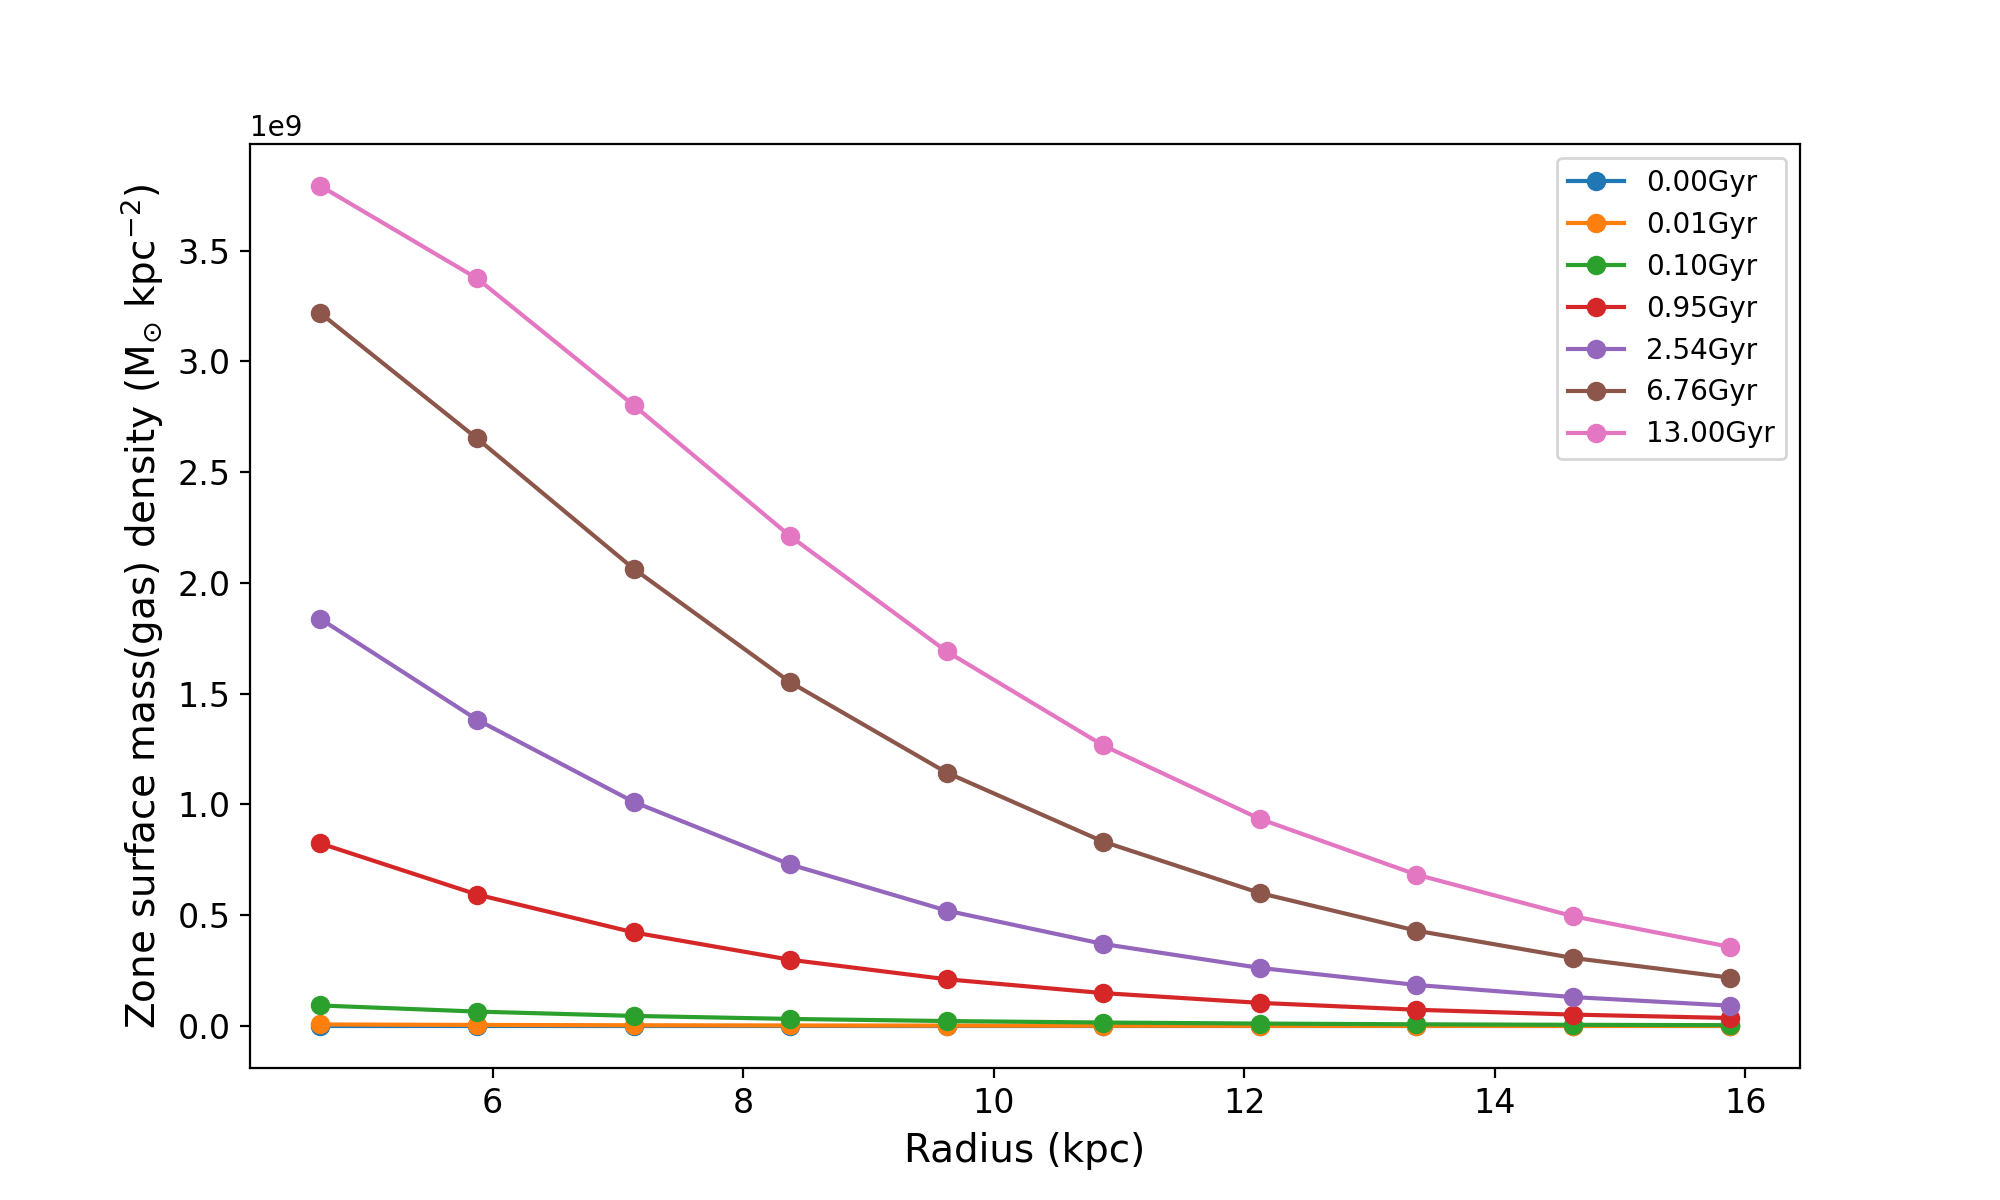

In [26]:
plt.figure(2, (10,6))

for i in ts:
    plot_radial_surface_mass(vers_test, omegas_test, bins_test, i)

<IPython.core.display.Javascript object>


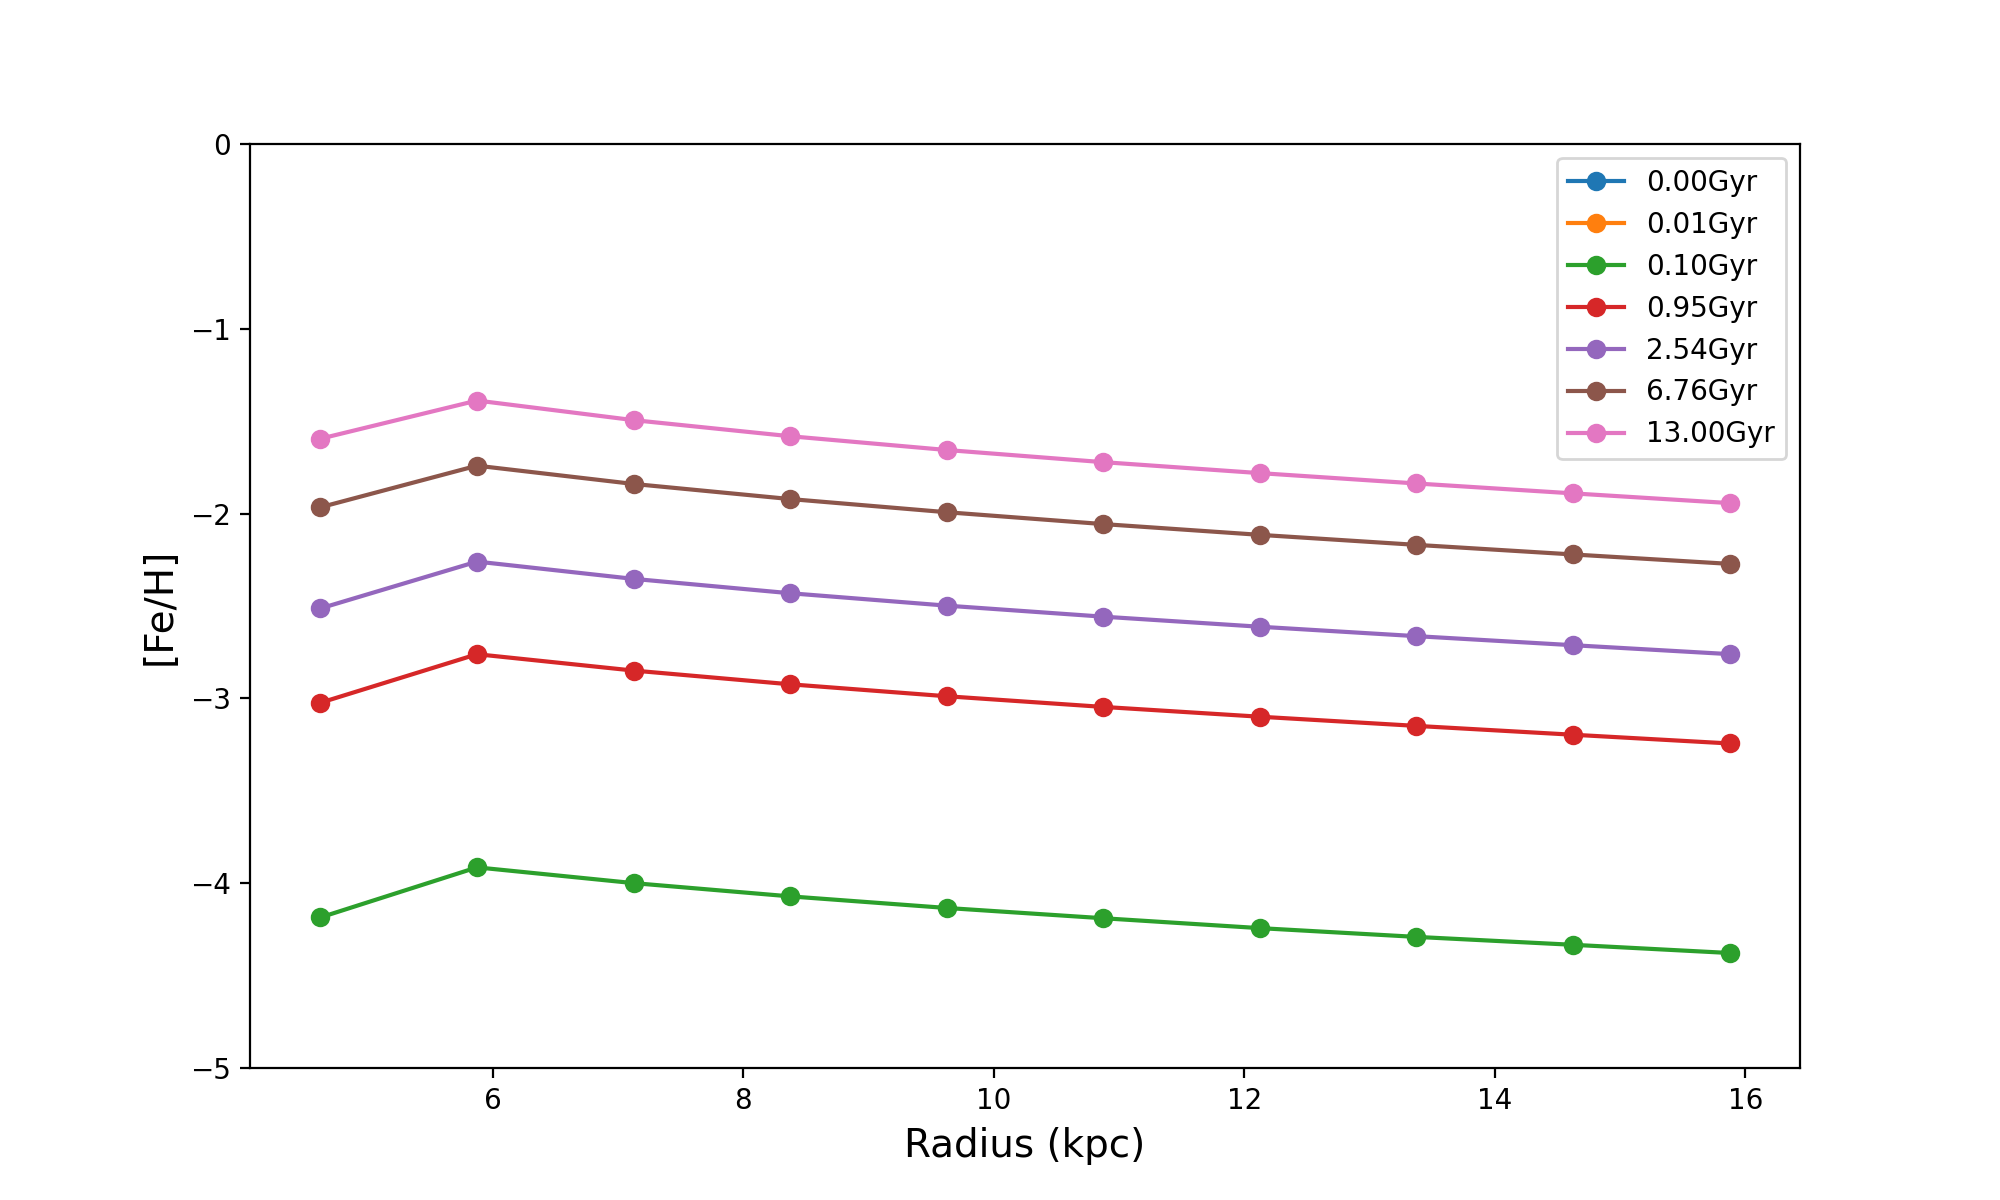

In [28]:
plt.figure(10, (10,6))

for i in ts:
    radial_plot_spectro(vers_test, omegas_test, bins_test, i, yaxis = '[Fe/H]')
    plt.ylim(-5,0)